In [1]:
# sudo apt install default-jre
# pip install requests
# pip install tabulate
# pip install "colorama >= 0.3.8"
# pip install future
# pip install matplotlib
# pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [2]:
!java -version

openjdk version "11.0.20" 2023-07-18
OpenJDK Runtime Environment (build 11.0.20+8-post-Debian-1deb11u1)
OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Debian-1deb11u1, mixed mode, sharing)


In [3]:
# Load the H2O library
import numpy as np
import pandas as pd
import h2o
import seaborn as sns
from IPython.display import display

In [4]:
# Initialize h2o cluster
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 3, ip = "localhost", port = 54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Debian-1deb11u1); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Debian-1deb11u1, mixed mode, sharing)
  Starting server from /opt/bitnami/python/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjeyvbfek
  JVM stdout: /tmp/tmpjeyvbfek/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjeyvbfek/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_xqfeij
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [5]:
dataset_csv = "smoking_driking_dataset_Ver01.csv"
data = h2o.import_file(dataset_csv, header = 1, sep =",")
print(str(data.shape[0]) + " x " + str(data.shape[1]))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
991346 x 24


In [6]:
display(data)

sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
Male,35,170,75,90,1,1,1,1,120,80,99,193,48,126,92,17.1,1,1,21,35,40,1,Y
Male,30,180,80,89,0.9,1.2,1,1,130,82,106,228,55,148,121,15.8,1,0.9,20,36,27,3,N
Male,40,165,75,91,1.2,1.5,1,1,120,70,98,136,41,74,104,15.8,1,0.9,47,32,68,1,N
Male,50,175,80,91,1.5,1.2,1,1,145,87,95,201,76,104,106,17.6,1,1.1,29,34,18,1,N
Male,50,165,60,80,1,1.2,1,1,138,82,101,199,61,117,104,13.8,1,0.8,19,12,25,1,N
Male,50,165,55,75,1.2,1.5,1,1,142,92,99,218,77,95,232,13.8,3,0.8,29,40,37,3,Y
Female,45,150,55,69,0.5,0.4,1,1,101,58,89,196,66,115,75,12.3,1,0.8,19,12,12,1,N
Male,35,175,65,84.2,1.2,1,1,1,132,80,94,185,58,107,101,14.4,1,0.8,18,18,35,3,Y
Male,55,170,75,84,1.2,0.9,1,1,145,85,104,217,56,141,100,15.1,1,0.8,32,23,26,1,Y
Male,40,175,75,82,1.5,1.5,1,1,132,105,100,195,60,118,83,13.9,1,0.9,21,38,16,2,Y


In [7]:
data['DRK_YN'] = data['DRK_YN'].asfactor()  #encode the binary repsonse as a factor
data['DRK_YN'].levels()  #optional: after encoding, this shows the two factor levels, '0' and '1'

[['N', 'Y']]

In [8]:
by_col = "age"
agr_value = data.group_by(by_col).count().get_frame().as_data_frame()
total = agr_value['nrow'].sum()
agr_value['percentage'] = round(agr_value['nrow'] / total * 100, 2)
agr_value = agr_value.sort_values(by_col)
print(agr_value)

    age    nrow  percentage
0    20   21971        2.22
1    25   64370        6.49
2    30   77600        7.83
3    35   84726        8.55
4    40  130385       13.15
5    45  118355       11.94
6    50  129434       13.06
7    55  111223       11.22
8    60  106063       10.70
9    65   52961        5.34
10   70   50666        5.11
11   75   25333        2.56
12   80   14968        1.51
13   85    3291        0.33


In [9]:
by_col = "age"
prob = list(np.arange(10, 100, 10)/100)
data[by_col].quantile(prob = prob)

Probs,ageQuantiles
0.1,30
0.2,35
0.3,40
0.4,45
0.5,45
0.6,50
0.7,55
0.8,60
0.9,65


In [10]:
# Stratified split
by_col = "age"
agr_value = data[by_col].unique().as_data_frame()
value_list = agr_value.iloc[:, 0].to_list()
value_list.sort()

for count, value in enumerate(value_list, start = 1):
    segment = data[data[by_col] == value]
    train_segment, valid_segment = segment.split_frame(ratios=[0.7], seed=1)
    if count == 1:
        train = train_segment
        valid = valid_segment
    else:
        train = train.rbind(train_segment)
        valid = valid.rbind(valid_segment)

print(str(train.shape[0]) + " x " + str(train.shape[1]))
print(str(valid.shape[0]) + " x " + str(valid.shape[1]))

total1 = data.shape[0]
total2 = train.shape[0] + valid.shape[0]

if total1 == total2:
    print("The total number of rows is correct")
else:
    print("The total number of rows is incorrect")

694415 x 24
296931 x 24
The total number of rows is correct


In [11]:
y = 'DRK_YN'
x = list(data.columns)
x.remove(y)  #remove the response

In [12]:
# Import H2O GLM:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [13]:
model = H2OGeneralizedLinearEstimator(family = "binomial")
model.train(y = y, x = x, training_frame = train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1697320466137_2


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 3.748E-4 )  24                            23                             4                       py_64_sid_a66b

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18163736230670016
RMSE: 0.42618935029714217
LogLoss: 0.5426778894209375
AUC: 0.802587853574916
AUCPR: 0.7899025635680382
Gini: 0.605175707149832
Null degrees of freedom: 694414
Residual degrees of freedom: 694391
Null deviance: 962662.7382985994
Residual deviance: 753814.7186438311
AIC: 753862.7186438311

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3553791784669741
       N       Y       Error    Rate
-----  ------  ------  -------  -------------------
N      196865  150729  0.4336   (150729.0/347594.0)
Y      49254   297567  0.142    (49254.0/346821.0)
Total  246119  448296  0.288    (199983.0/694415.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355379     0.748486  265
max f2                       0.186442     0.851406  341
max f0point5                 0.566663     0.73042   178
max accuracy                 0.478437     0.726269  213
max precision                0.938603     0.940789  20
max recall                   0.00297684   1         399
max specificity              0.999405     0.999574  0
max absolute_mcc             0.441007     0.4535    228
max min_per_class_accuracy   0.491361     0.725021  208
max mean_per_class_accuracy  0.478437     0.726285  213
max tns                      0.999405     347446    0
max fns                      0.999405     345386    0
max fps                      0.00297684   347594    399
max tps                      0.00297684   346821    399
max tnr                      0.999405     0.999574  0
max fnr                      0.999405     0.995862  0
max fpr                      0.00297684   1         399
max tpr                      0.00297684   1         399

Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100012                   0.973079           1.85721   1.85721            0.927574         0.988931  0.927574                    0.988931            0.0185744       0.0185744                  85.7215   85.7215            0.0171273
2        0.020001                    0.94801            1.90391   1.88056            0.950893         0.959711  0.939232                    0.974322            0.0190386       0.0376131                  90.3905   88.0558            0.0351849
3        0.0300008                   0.930629           1.88545   1.88219            0.941676         0.938991  0.940047                    0.962546            0.0188541       0.0564672                  88.5451   88.2189            0.0528739
4        0.0400006                   0.916591           1.84854   1.87378            0.923243         0.923481  0.935846                    0.95278             0.018485       

In [14]:
# Eval performance:
valid_perf1 = model.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(valid_perf1.auc()))
print("Gini: " + str(valid_perf1.gini()))

AUC: 0.8020729716470627
Gini: 0.6041459432941254


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           84046   64218
Y           21525  127142


<Axes: xlabel='Prediction', ylabel='Original'>

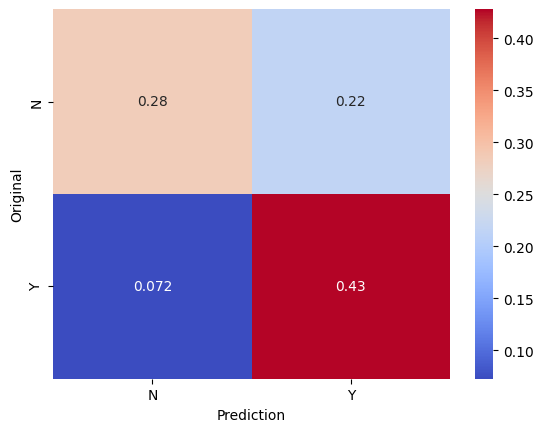

In [15]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = model.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [16]:
from h2o.estimators import H2ODeepLearningEstimator

In [17]:
# Initialize and train the DL estimator:
dl_model = H2ODeepLearningEstimator(seed=1)
dl_model.train(x = x, y = y, training_frame = train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1697320466137_5


Status of Neuron Layers: predicting DRK_YN, 2-class classification, bernoulli distribution, CrossEntropy loss, 45,802 weights/biases, 548.6 KB, 7,000,749 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate            rate_rms              momentum    mean_weight           weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  -------------------  --------------------  ----------  --------------------  -------------------  -------------------  -------------------
    1        25       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.05170610226102435  0.19729626178741455   0.0         -0.05707175469533831  0.4075392484664917   -0.508885925497552   0.36657512187957764
    3        200      Rectifier  0.0        0.0   0.0   0.17238586712325432  0.14210659265518188   0.0         -0.06511128296634612  0.10646936297416687  0.17206655257536807  0.2013881802558899
    4        2        Softmax               0.0   0.0   0.00946690798344207  0.004103098064661026  0.0         0.00997569099003158   0.31400465965270996  0.07994303678624626  0.1407390832901001

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1710891112511585
RMSE: 0.4136291953563705
LogLoss: 0.5132293033801507
Mean Per-Class Error: 0.2739632617893188
AUC: 0.8243595013015482
AUCPR: 0.8312330247539288
Gini: 0.6487190026030965

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3901158443518235
       N     Y     Error    Rate
-----  ----  ----  -------  ---------------
N      2924  1942  0.3991   (1942.0/4866.0)
Y      751   4295  0.1488   (751.0/5046.0)
Total  3675  6237  0.2717   (2693.0/9912.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390116     0.761322  248
max f2                       0.265471     0.855076  302
max f0point5                 0.561391     0.762512  176
max accuracy                 0.516744     0.745763  195
max precision                0.999054     1         0
max recall                   0.0111288    1         397
max specificity              0.999054     1         0
max absolute_mcc             0.542251     0.494567  184
max min_per_class_accuracy   0.495514     0.741882  203
max mean_per_class_accuracy  0.542251     0.746489  184
max tns                      0.999054     4866      0
max fns                      0.999054     5028      0
max fps                      0.00140758   4866      399
max tps                      0.0111288    5046      397
max tnr                      0.999054     1         0
max fnr                      0.999054     0.996433  0
max fpr                      0.00140758   1         399
max tpr                      0.0111288    1         397

Gains/Lift Table: Avg response rate: 50.91 %, avg score: 51.16 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100888                   0.98937            1.96433   1.96433            1                0.994633   1                           0.994633            0.0198177       0.0198177                  96.4328   96.4328            0.0198177
2        0.0200767                   0.979774           1.94449   1.95446            0.989899         0.984648   0.994975                    0.989666       

In [18]:
# Eval performance:
valid_perf2 = dl_model.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(valid_perf2.auc()))
print("Gini: " + str(valid_perf2.gini()))

AUC: 0.820242658586079
Gini: 0.6404853171721581


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           90190   58074
Y           23345  125322


<Axes: xlabel='Prediction', ylabel='Original'>

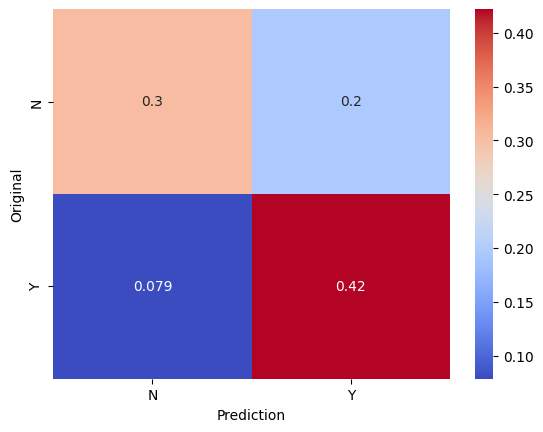

In [19]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = dl_model.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [20]:
from h2o.estimators import H2ORandomForestEstimator

In [21]:
model_rf = H2ORandomForestEstimator(ntrees = 200, max_depth = 7, min_rows=10)
model_rf.train(x = x, y = y, training_frame = train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1697320466137_24


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    200                200                         330201                 7            7            7             120           128           126.92

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.18481281467255825
RMSE: 0.4298986097588107
LogLoss: 0.5494831774163538
Mean Per-Class Error: 0.2987640690863609
AUC: 0.7983736915465618
AUCPR: 0.7921086006430742
Gini: 0.5967473830931236

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3886366527553969
       N       Y       Error    Rate
-----  ------  ------  -------  -------------------
N      184502  163092  0.4692   (163092.0/347594.0)
Y      44506   302315  0.1283   (44506.0/346821.0)
Total  229008  465407  0.299    (207598.0/694415.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388637     0.744409  265
max f2                       0.212499     0.850902  345
max f0point5                 0.604292     0.725615  150
max accuracy                 0.481447     0.717454  215
max precision                0.874516     0.987582  4
max recall                   0.0770545    1         399
max specificity              0.890825     0.999997  0
max absolute_mcc             0.446656     0.438469  234
max min_per_class_accuracy   0.507842     0.715458  201
max mean_per_class_accuracy  0.481447     0.71749   215
max tns                      0.890825     347593    0
max fns                      0.890825     346752    0
max fps                      0.0770545    347594    399
max tps                      0.0770545    346821    399
max tnr                      0.890825     0.999997  0
max fnr                      0.890825     0.999801  0
max fpr                      0.0770545    1         399
max tpr                      0.0770545    1         399

Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100012                   0.858205           1.95725   1.95725            0.977538         0.86787   0.977538                    0.86787             0.0195749       0.0195749                  95.7254   95.7254            0.0191261
2        0.020001                    0.846515           1.92438   1.94082            0.961118         0.852123  0.969328                    0.859997            0.0192434       0.0388183                  92.4377   94.0817            0.0375927
3        0.0300008                   0.837555           1.89266   1.92477            0.945276         0.841881  0.961311                    0.853959            0.0189262       0.0577445                  89.266    92.4765            0.0554257
4        0.0400006                   0.829987           1.85431   1.90715            0.926123         0.833688  0.952515                    0.848891            0.0185427       0.0762872                  85.4311   90.7152            0.0724925
5        0.0500004                   0.823187           1.84076   1.89387            0.919355         0.826579  0.9

In [22]:
# Eval performance:
valid_perf3 = model_rf.model_performance(valid)

# Retreive test set AUC and Gini
print("AUC: " + str(valid_perf3.auc()))
print("Gini: " + str(valid_perf3.gini()))

AUC: 0.7982716108125436
Gini: 0.5965432216250872


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Prediction      N       Y
Original                 
N           79006   69258
Y           19331  129336


<Axes: xlabel='Prediction', ylabel='Original'>

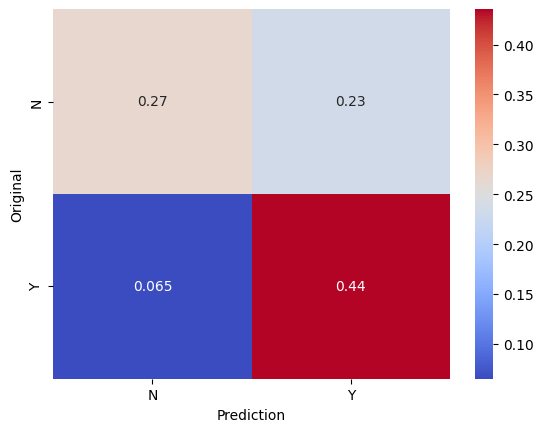

In [23]:
y = 'DRK_YN'
y_df = valid[y].as_data_frame()
y_orig = y_df[y]

valid_pred = model_rf.predict(valid).as_data_frame()
y_pred = valid_pred['predict']

ct_target = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"])
print(ct_target)
ct_normalize = pd.crosstab(y_orig, y_pred, rownames = ["Original"], colnames = ["Prediction"], normalize = True)
sns.heatmap(ct_normalize, cmap='coolwarm', annot=True)

In [24]:
# Shutdown cluster
h2o.cluster().shutdown()

H2O session _sid_a66b closed.
